In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

In [2]:
house = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/Solar_Energy_Prediction/House_2_Processed_TimeSeries.csv')
house2 = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/Solar_Energy_Prediction/House_3_Processed_TimeSeries.csv')
house3 = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/Solar_Energy_Prediction/House_4_Processed_TimeSeries.csv')
states = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/Solar_Energy_Prediction/state_appliance_combinations.csv')
house2.head(5)

,Unnamed: 0,Time,Temperature,PV_V,Digit,Battery_V,Digit2,PV_Current,Battery_Current,PV_Power,Battery_Power,Load,Load_Corrected,Solar_Irradiance,Spillage
0,0,2015-06-23 12:28:00,30.40,18.37,32777,12.89,32779,-0.114042,-0.09240,-2.094952,-1.191036,-3.285988,0.000000,-31.480545,0.000000
1,1,2015-06-23 12:29:00,30.42,18.95,32776,12.88,32779,-0.095035,-0.09240,-1.800913,-1.190112,-2.991025,0.000000,-27.062072,0.000000
2,2,2015-06-23 12:30:00,30.43,18.79,32774,12.88,32777,-0.057021,-0.05544,-1.071425,-0.714067,-1.785492,0.000000,-16.100148,0.000000
3,3,2015-06-23 12:31:00,30.43,13.30,32760,12.80,32750,0.209077,0.44352,2.780724,5.677056,8.457780,8.457780,41.785553,8.457780
4,4,2015-06-23 12:32:00,30.42,13.23,32766,12.75,32745,0.095035,0.53592,1.257313,6.832980,8.090293,8.090293,18.893468,8.090293


In [3]:
states.head(10)

,State,Expected_Mean_Power,Appliance_Combination
0,1,0,None
1,2,9,1_CFL
2,3,14,1_Fan
3,4,18,2_CFL
4,5,23,1_Fan_1_CFL
5,6,27,3_CFL
6,7,32,2_CFL_1_Fan
7,8,36,4_CFL
8,9,41,3_CFL_1_Fan
9,10,50,4_CFL_1_Fan


In [4]:
def conditions(x):
    if x == 0:
        return '1'
    elif x > 0 and x <= 9:
        return '2'
    elif x > 9 and x <= 14:
        return '3'
    elif x > 14 and x <=18:
        return '4'
    elif x > 18 and x <=23:
        return '5'
    elif x > 23 and x <=27:
        return '6'
    elif x > 27 and x <=32:
        return '7'
    elif x > 32 and x <= 36:
        return '8'
    elif x > 36 and x <= 41:
        return '9'
    else:
        return '10'
    

func = np.vectorize(conditions)
energy_class = func(house['Load_Corrected'])
house['State'] = energy_class

In [5]:
house.shape

(319756, 18)

In [6]:
house['State'].value_counts().reset_index()


,index,State
0,1,193632
1,2,79220
2,4,22295
3,6,10779
4,3,7810
5,8,2856
6,5,2122
7,7,941
8,9,53
9,10,48


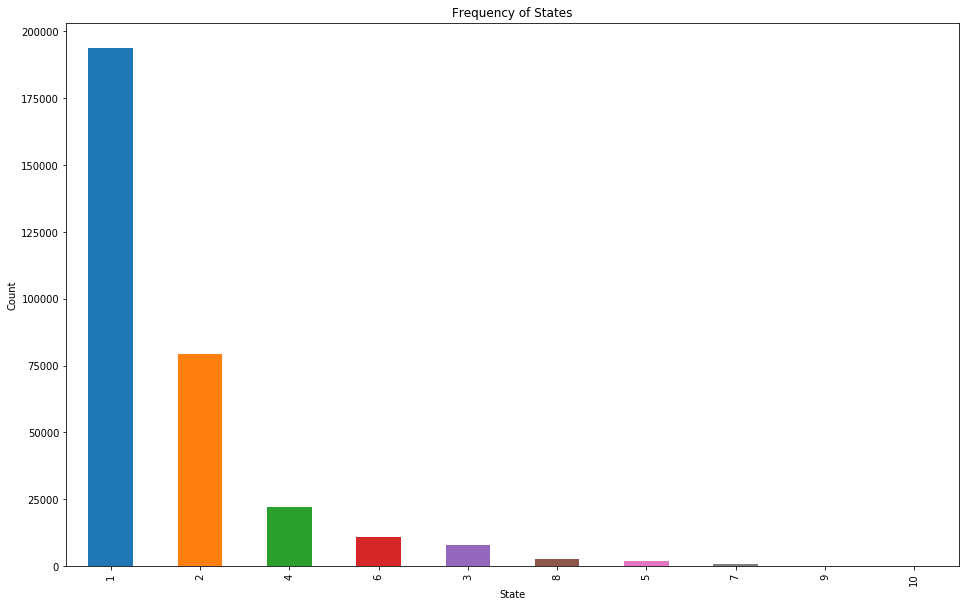

In [7]:
plt.figure(figsize=(16,10))
house['State'].value_counts().plot(kind='bar', title='Frequency of States')
plt.xlabel("State")
plt.ylabel("Count")
plt.show()

<Figure size 1152x864 with 0 Axes>

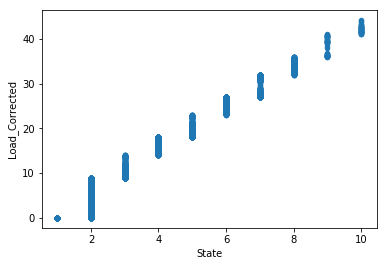

In [8]:
plt.figure(figsize=(16,12))
house['State'] = house['State'].astype('int64')
house.plot(x='State', y='Load_Corrected', kind='scatter')
plt.show()

## KMeans Cluster Models

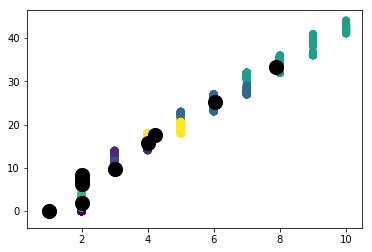

In [9]:
# fit Kmeans
states_load = house.loc[:,['State','Load_Corrected']]
X = np.array(states_load.loc[:,'Load_Corrected']).reshape(-1,1)
y = np.array(states_load.loc[:,'State']).reshape(-1,1)
kmeans = KMeans(n_clusters=10)
kmeans.fit(states_load)
y_kmeans = kmeans.predict(states_load)

# Plot clusters
plt.scatter(states_load.loc[:, 'State'], states_load.loc[:, 'Load_Corrected'], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0],  centers[:, 1], c='black', s=200, alpha=1)

### State initialisation

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


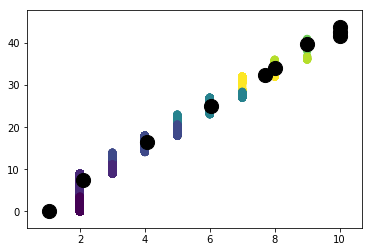

In [10]:
## Initialise cluster centers with averages for each state

temp = states_load.groupby('State')['Load_Corrected'].mean()
temp_ar = np.array(temp)
states = [1,2,3,4,5,6,7,8,9,10]
averaged = np.column_stack((temp,states))

# fit Kmeans
X = np.array(states_load.loc[:,'Load_Corrected']).reshape(-1,1)
y = np.array(states_load.loc[:,'State']).reshape(-1,1)
kmeans = KMeans(n_clusters=10, init=averaged)
kmeans.fit(states_load)
y_kmeans = kmeans.predict(states_load)

plt.scatter(states_load.loc[:, 'State'], states_load.loc[:, 'Load_Corrected'], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0],  centers[:,1], c='black', s=200, alpha=1)

### Scale variables and compare initialisation method accuracy 

In [11]:
scaled = StandardScaler()
states_scaled = scaled.fit_transform(X)
states = states_load['State']
states_scaled = np.column_stack((states,states_scaled))

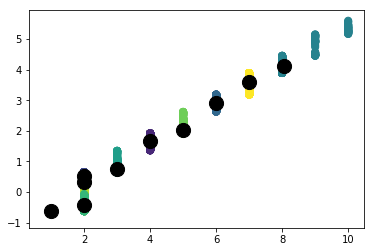

In [12]:
# Cluster
kmeans = KMeans(n_clusters=10)
kmeans.fit(states_scaled)
y_kmeans = kmeans.predict(states_scaled)

plt.scatter(states_scaled[:,0], states_scaled[:,1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0],  centers[:,1], c='black', s=200, alpha=1)

Evaluation of KMeans with k-means++ init
Evaluation of KMeans with random init
Evaluation of KMeans with [[ 0.          1.        ]
 [ 6.71036356  2.        ]
 [ 9.66841154  3.        ]
 [16.29018343  4.        ]
 [18.87594505  5.        ]
 [25.06220111  6.        ]
 [30.00689768  7.        ]
 [33.32743651  8.        ]
 [38.3894043   9.        ]
 [42.15167598 10.        ]] init


/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Evaluation of KMeans with k-means++ init
Evaluation of KMeans with random init
Evaluation of KMeans with [[ 0.          1.        ]
 [ 6.71036356  2.        ]
 [ 9.66841154  3.        ]
 [16.29018343  4.        ]
 [18.87594505  5.        ]
 [25.06220111  6.        ]
 [30.00689768  7.        ]
 [33.32743651  8.        ]
 [38.3894043   9.        ]
 [42.15167598 10.        ]] init


Text(0.5,0,'Initialisation')

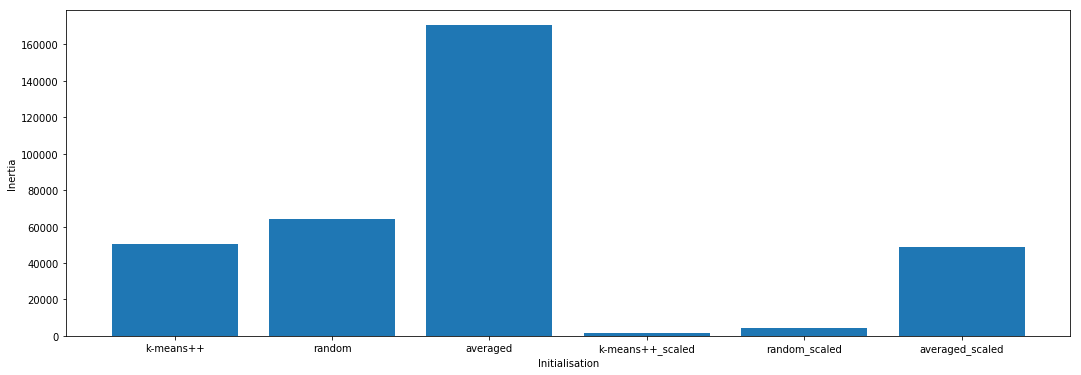

In [13]:
## Compare methods of initialisation with KMeans, Random, and a dictionary with cluster center initialisation using calculated means

cases = [
    (KMeans, 1,'k-means++', {}),
    (KMeans,2, 'random', {}),
    (KMeans,3, averaged, {})
]
n_clusters = 10


# Inertia is defined as the sum of squared distances to the nearest cluster center
inertia = {}

# Regular data set
for factory, i, init, params in cases:
    print("Evaluation of %s with %s init" % (factory.__name__, init))
    km = factory(n_clusters, init=init, **params).fit(states_load)
    if i == 3:
        init = 'averaged'
        inertia[init] = km.inertia_       
    else:
        inertia[init] = km.inertia_

# Scaled data set 
for factory, i, init, params in cases:
    print("Evaluation of %s with %s init" % (factory.__name__, init))
    km = factory(n_clusters, init=init, **params).fit(states_scaled)
    if i == 3:
        init = 'averaged'
        init = init + '_scaled'
        inertia[init] = km.inertia_       
    else:
        init = init + '_scaled'
        inertia[init] = km.inertia_
        
# Plot comparison 

plt.figure(figsize=(18,6))
plt.bar(range(len(inertia)), list(inertia.values()))
plt.xticks(range(len(inertia)), list(inertia.keys()))
plt.ylabel('Inertia')
plt.xlabel('Initialisation')
    

## Gaussian Mixture Models

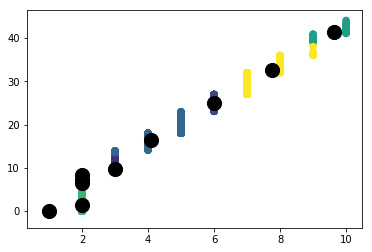

In [18]:
gmm = GaussianMixture(n_components=10).fit(states_load)
centers = gmm.means_
labels = gmm.predict(states_load)

plt.scatter(states_load.loc[:, 'State'], states_load.loc[:, 'Load_Corrected'], c=labels, s=40, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=1)

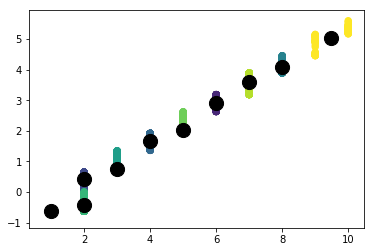

In [20]:
### Scaled variables 

gmm = GaussianMixture(n_components=10).fit(states_scaled)
centers = gmm.means_
labels = gmm.predict(states_scaled)

plt.scatter(states_scaled[:,0], states_scaled[:,1], c=labels, s=40, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=1)

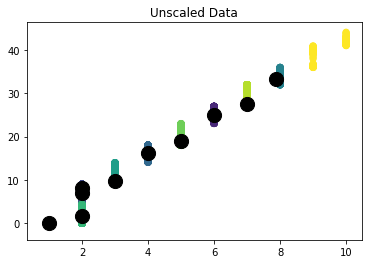

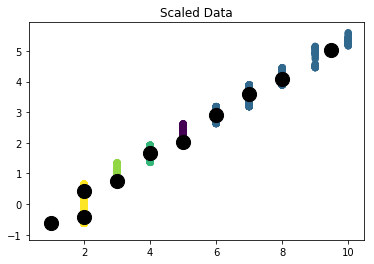

In [23]:
## Covariance type = full 

gmm_cov = GaussianMixture(n_components=10, covariance_type='full').fit(states_load)
centers_cov = gmm_cov.means_
labels - gmm_cov.predict(states_load)

# Scaled data
gmm_cov_scaled = GaussianMixture(n_components=10, covariance_type='full').fit(states_scaled)
centers_cov_scaled = gmm.means_
labels_scaled = gmm_cov.predict(states_scaled)

plt.scatter(states_load.loc[:, 'State'], states_load.loc[:, 'Load_Corrected'], c=labels, s=40, cmap='viridis')
plt.title("Unscaled Data")
plt.scatter(centers_cov[:, 0], centers_cov[:, 1], c='black', s=200, alpha=1)
plt.show()

plt.scatter(states_scaled[:,0], states_scaled[:,1], c=labels_scaled, s=40, cmap='viridis')
plt.title("Scaled Data")
plt.scatter(centers_cov_scaled[:, 0], centers_cov_scaled[:, 1], c='black', s=200, alpha=1)
plt.show()

In [ ]:
## Plot BIC and AIC for a range of components using scaled data set 

n_components = np.arange(1, 12)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(states_scaled)
          for n in n_components]

plt.figure(figsize=(16,8))
plt.plot(n_components, [m.bic(states_scaled) for m in models], label='BIC')
plt.plot(n_components, [m.aic(states_scaled) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

## Hierarchical Clustering Models

In [ ]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(states_scaled, method='ward'))
# create clusters
hc = AgglomerativeClustering(n_clusters=10, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(states_scaled)

In [1]:
plt.scatter(states_scaled[y_hc ==0,0], states_scaled[y_hc == 0,1], s=100, c='red')
plt.scatter(states_scaled[y_hc==1,0], states_scaled[y_hc == 1,1], s=100, c='black')
plt.scatter(states_scaled[y_hc ==2,0], states_scaled[y_hc == 2,1], s=100, c='blue')
plt.scatter(states_scaled[y_hc ==3,0], states_scaled[y_hc == 3,1], s=100, c='green')

NameError: name 'plt' is not defined